In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product, permutations

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, entropy, ks_2samp

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import csv

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
params = (10., 28., 8/3)

x = get_data(*params)
points_number = x.shape[0]

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50 # right shift value
M = 20 # iterations number

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives_list, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          vec = x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]]
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - vec)
            St.extend(motive[i][(normalized_predicted < max_dist), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
def calculate(train_points_number, begin, steps=M):
    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    motives_list = []

    for i in tqdm(range(steps), "Overall iterations loop"):
        start = begin + step * i
        motives = fit(x, train_points_number, start, current_iter=i + 1, max_iter=steps)
        motives_list.append(motives)

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, [motives], start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(steps):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= steps
    unpredicted_points /= steps

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points, motives_list

In [10]:
def calculate_mixed(train_points_number, begin, y_params, steps=M):
    data = [x]
    for param in y_params:
        data.append(get_data(*param))

    actual_vals_matrix = []
    predicted_vals_matrix = []
    
    for i in tqdm(range(steps), "Overall iterations loop"):
        start = begin + step * i

        motives_list = [fit(arr, train_points_number, start, current_iter=i + 1, max_iter=M) for arr in data]

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        predicted_vals = predict_with_demon(x, motives_list, start + train_points_number, predicted_points_number)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(steps):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= steps
    unpredicted_points /= steps

    return actual_vals_matrix, predicted_vals_matrix, loss, unpredicted_points

In [11]:
def plots(train_points_number, data):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series + alike series, train_size={train_points_number}")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(data[2])

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(data[3])

    plt.show()

In [12]:
train_points_number = 1000
begin = 0

In [13]:
perms = np.array(list(permutations(range(L + 1))))

In [14]:
def calculate_probability_vector(train_data):
    X = fit(train_data, train_points_number, begin)
    counts = {tuple(x) : 0 for x in perms}
    for i in tqdm(range(len(X)), desc="Calculating", leave=False):
        Y = np.argsort(X[i], axis=1)
        for j in Y:
            counts[tuple(j)] += 1
    prob_vec = np.array(list(counts.values())) / sum(counts.values())

    return prob_vec

In [ ]:
vecs = []
for p1 in tqdm(np.linspace(0.98, 1.02, 5), desc="Outer loop"):
    for p2 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner loop", leave=False):
        for p3 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner inner loop", leave=False):
            y = get_data(params[0] * p1, params[1] * p2, params[2] * p3)
            vec = [p1, p2, p3]
            prob_vec = calculate_probability_vector(y)
            vec.extend(prob_vec)

            vecs.append(vec)

In [135]:
import csv

with open('probability_vectors.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for data in vecs:
        writer.writerow(list(map(str, data)))

In [35]:
def calculate_entropy_metric(p1, p2):
    return entropy((p1 + p2) / 2) - 0.5 * entropy(p1) - 0.5 * entropy(p2)

In [71]:
x_vec = vecs[62][3:]

In [75]:
s1, s2 = [], []

for i in range(len(vecs)):
    vec = vecs[i][3:]
    s1.append([np.linalg.norm(np.array(vec) - np.array(x_vec)), i])
    s2.append([calculate_entropy_metric(np.array(vec), np.array(x_vec)), i])
s1_ = sorted(s1)
s2_ = sorted(s2)

In [36]:
def dtw_distance(series1, series2):
    series1 = np.array(series1).reshape(-1, 1)
    series2 = np.array(series2).reshape(-1, 1)
    distance, _ = fastdtw(series1, series2, dist=euclidean)
    return distance

In [ ]:
s3 = []
k = 0

for p1 in tqdm(np.linspace(0.98, 1.02, 5), desc="Outer loop"):
    for p2 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner loop", leave=False):
        for p3 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner inner loop", leave=False):
            y = get_data(params[0] * p1, params[1] * p2, params[2] * p3)
            dst = dtw_distance(x[:train_points_number + step * M], y[:train_points_number + step * M])
            s3.append([dst, k])
            k += 1
s3_ = sorted(s3)

In [ ]:
s4 = []
k = 0

for p1 in tqdm(np.linspace(0.98, 1.02, 5), desc="Outer loop"):
    for p2 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner loop", leave=False):
        for p3 in tqdm(np.linspace(0.98, 1.02, 5), desc="Inner inner loop", leave=False):
            y = get_data(params[0] * p1, params[1] * p2, params[2] * p3)
            colm = np.mean([ks_2samp(x[begin + step * j: begin + step * j + train_points_number], y[begin + step * j: begin + step * j + train_points_number])[0] for j in range(M)])
            s4.append([colm, k])
            k += 1
s4_ = sorted(s4)

In [15]:
y1, y2, y3, y4 = np.zeros((125)), np.zeros((125)), np.zeros((125)), np.zeros((125))

In [106]:
for i in range(len(s1_)):
    y1[s1_[i][1]] = i

for i in range(len(s2_)):
    y2[s2_[i][1]] = i

for i in range(len(s3_)):
    y3[s3_[i][1]] = i

for i in range(len(s4_)):
    y4[s4_[i][1]] = i

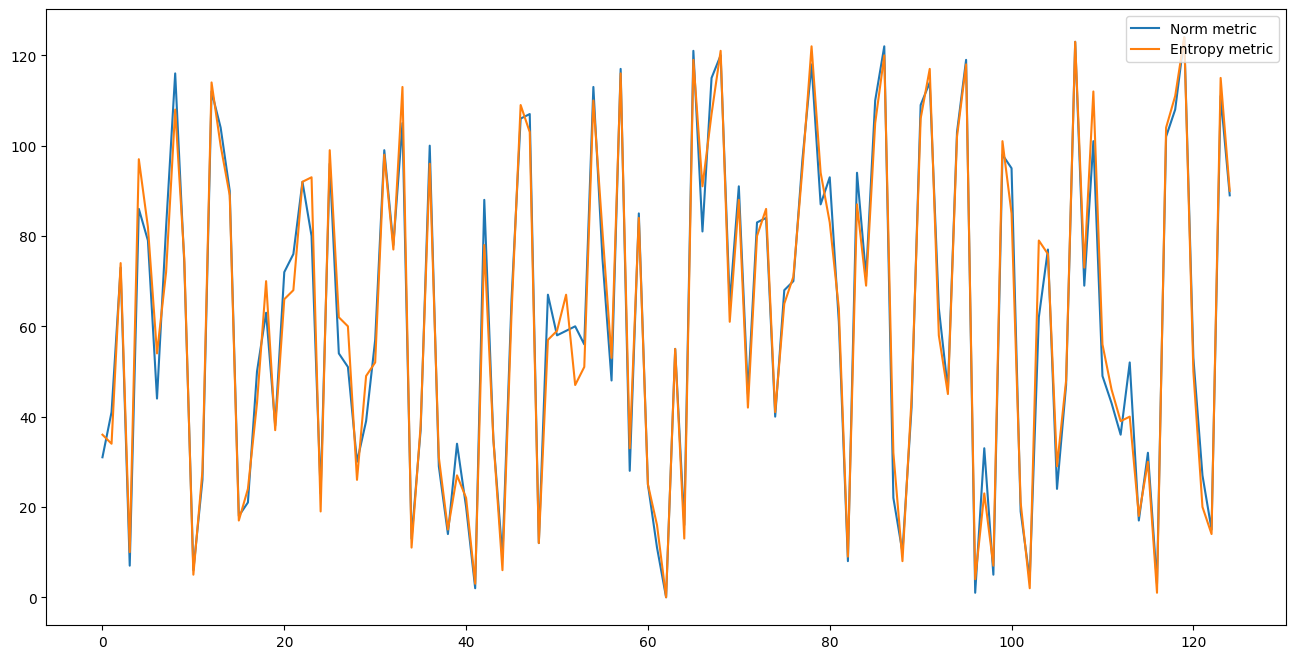

In [3]:
plt.figure(figsize=(16, 8))
plt.plot(y1, label="Norm metric")
plt.plot(y2, label="Entropy metric")
# plt.plot(y3, label="DTW metric")
# plt.plot(y4, label="Colmogorov metric")
plt.legend(loc="upper right")
plt.show()

In [111]:
import csv

with open('series_positions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    k = 0
    for p1 in np.linspace(0.98, 1.02, 5):
        for p2 in np.linspace(0.98, 1.02, 5):
            for p3 in np.linspace(0.98, 1.02, 5):
                writer.writerow(list(map(str, [p1, p2, p3, int(y1[k]), int(y2[k]), int(y3[k]), int(y4[k])])))
                k += 1

In [2]:
y1, y2, y3, y4 = np.zeros((125)), np.zeros((125)), np.zeros((125)), np.zeros((125))

with open('series_positions.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|')
    for i, row in enumerate(reader):
        y1[i], y2[i], y3[i], y4[i] = list(map(int, row[3:]))

In [17]:
places = np.array(y1) + np.array(y2)
places = [i[1] for i in sorted([[places[i], i] for i in range(len(places))])]

In [19]:
coeffs = []
for p1 in np.linspace(0.98, 1.02, 5):
    for p2 in np.linspace(0.98, 1.02, 5):
        for p3 in np.linspace(0.98, 1.02, 5):
            coeffs.append(np.array([p1, p2, p3]))

Mixing 1

In [ ]:
mat1 = np.array([
    coeffs[places[1]]
])
data1 = calculate_mixed(train_points_number, begin, mat1 * params)

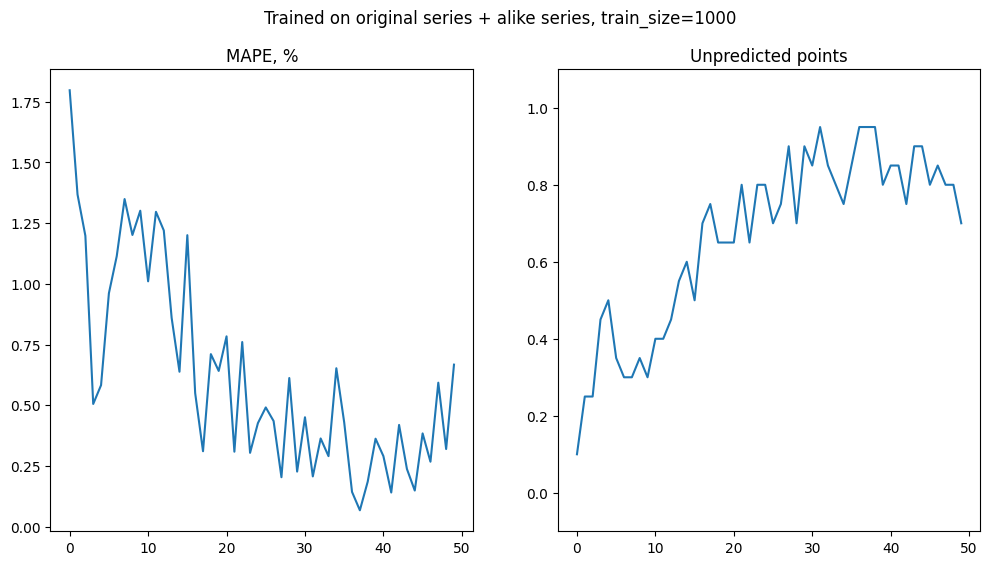

In [134]:
plots(train_points_number, data1)

In [133]:
print(np.mean(data1[3]))

0.667


Mixing 2

In [ ]:
mat2 = np.array([
    coeffs[places[2]]
])
data2 = calculate_mixed(train_points_number, begin, mat2 * params)

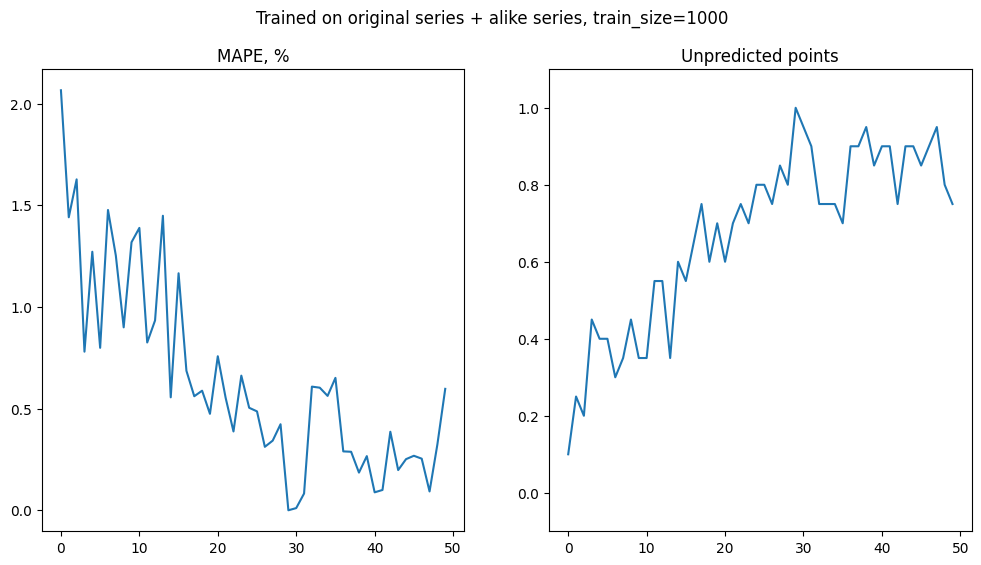

In [25]:
plots(train_points_number, data2)

In [26]:
print(np.mean(data2[3]))

0.6729999999999999


Mixing 3

In [ ]:
mat3 = np.array([
    coeffs[places[3]]
])
data3 = calculate_mixed(train_points_number, begin, mat3 * params)

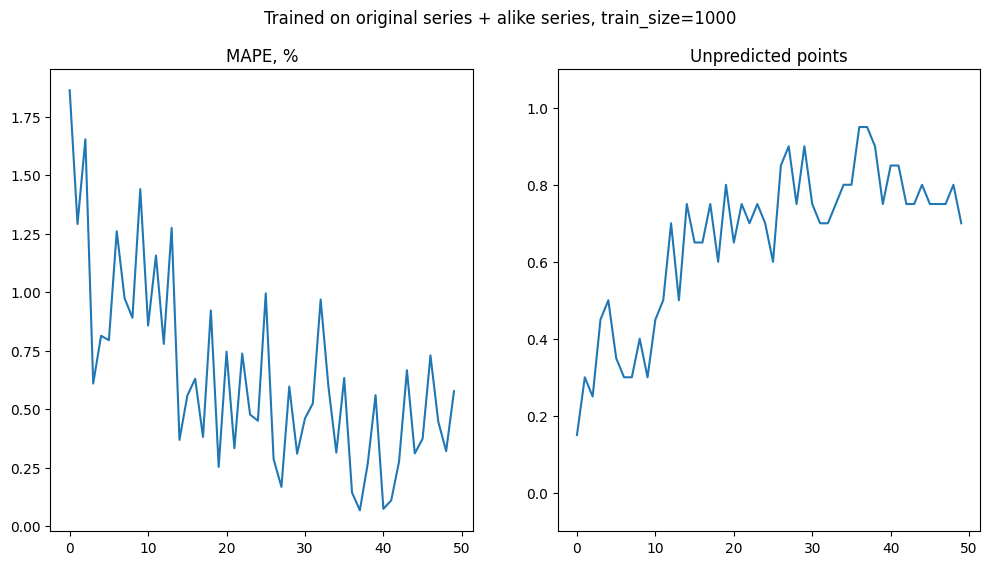

In [28]:
plots(train_points_number, data3)

In [29]:
print(np.mean(data3[3]))

0.66


Mixing 4

In [ ]:
mat4 = np.array([
    coeffs[places[4]]
])
data4 = calculate_mixed(train_points_number, begin, mat4 * params)

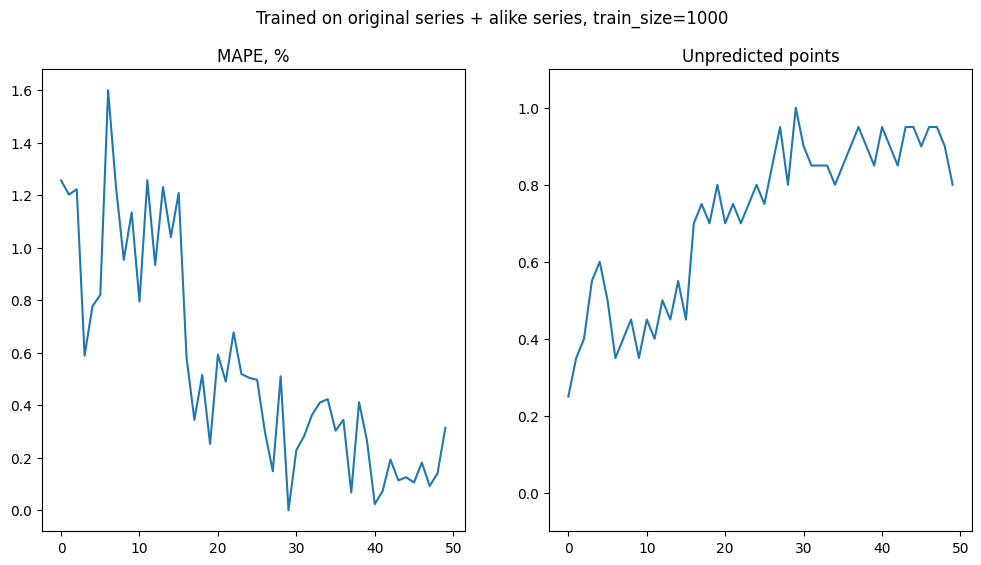

In [31]:
plots(train_points_number, data4)

In [32]:
print(np.mean(data4[3]))

0.716


Mixing 5

In [ ]:
mat5 = np.array([
    coeffs[places[5]]
])
data5 = calculate_mixed(train_points_number, begin, mat5 * params)

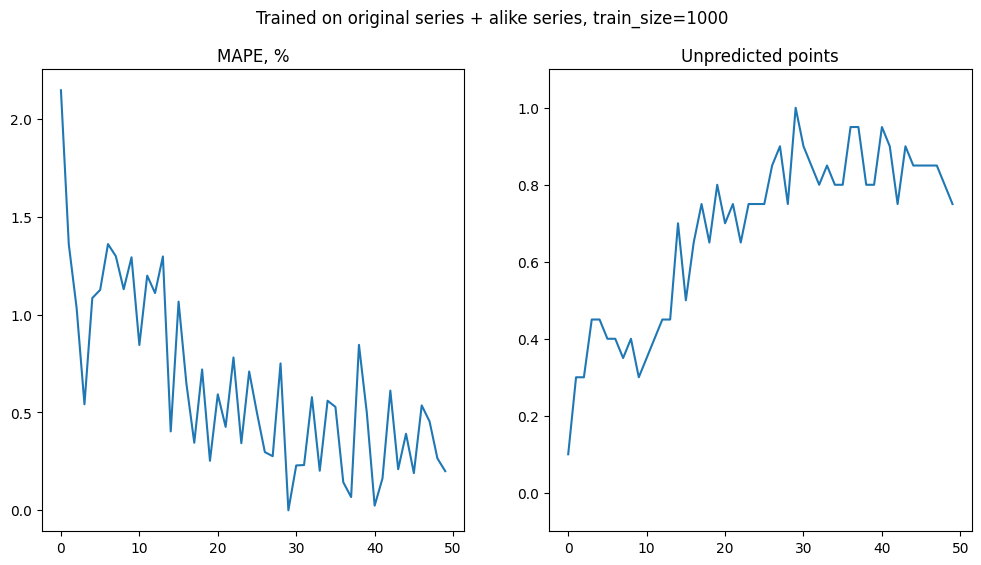

In [34]:
plots(train_points_number, data5)

In [35]:
print(np.mean(data5[3]))

0.6789999999999999


Mixing 6

In [ ]:
mat6 = np.array([
    coeffs[places[1]],
    coeffs[places[2]],
    coeffs[places[3]],
    coeffs[places[4]],
    coeffs[places[5]]
])
data6 = calculate_mixed(train_points_number, begin, mat6 * params)

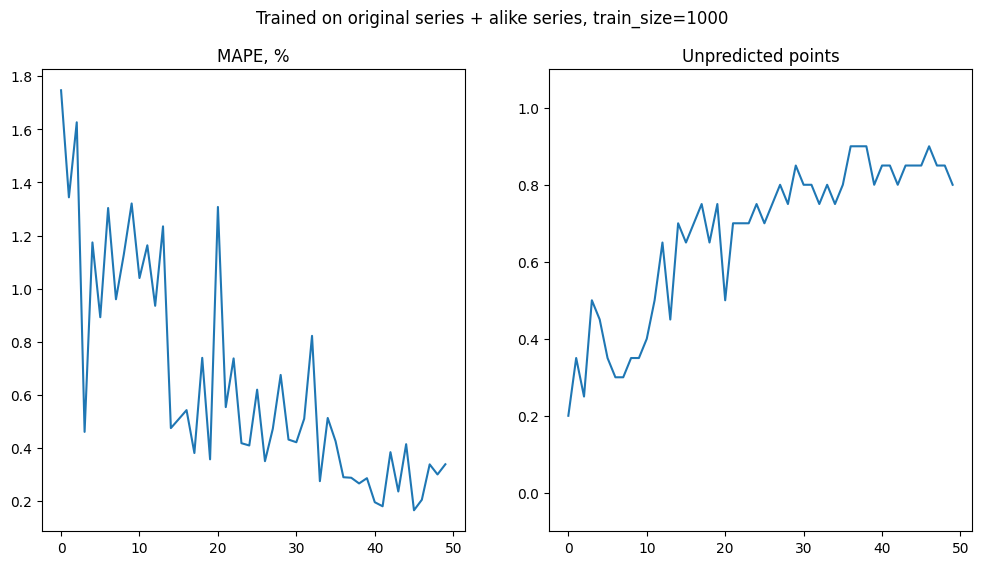

In [37]:
plots(train_points_number, data6)

In [38]:
print(np.mean(data6[3]))

0.6689999999999999


Mixing 7

In [ ]:
mat7 = np.array([
    coeffs[places[6]]
])
data7 = calculate_mixed(train_points_number, begin, mat7 * params)

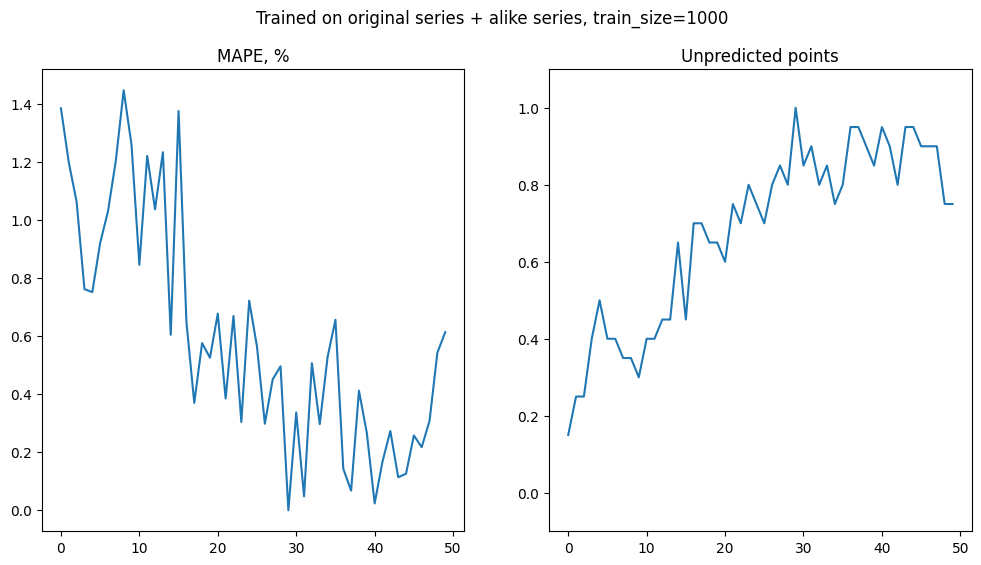

In [42]:
plots(train_points_number, data7)

In [43]:
print(np.mean(data7[3]))

0.679


Mixing 8

In [ ]:
mat8 = np.array([
    coeffs[places[7]]
])
data8 = calculate_mixed(train_points_number, begin, mat8 * params)

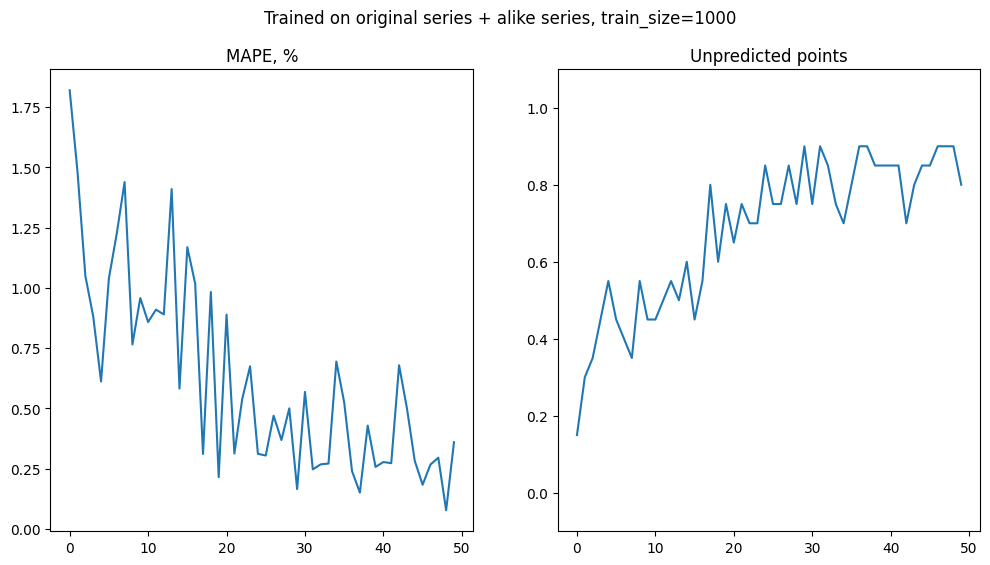

In [45]:
plots(train_points_number, data8)

In [46]:
print(np.mean(data8[3]))

0.6809999999999999


Mixing 9

In [ ]:
mat9 = np.array([
    coeffs[places[8]]
])
data9 = calculate_mixed(train_points_number, begin, mat9 * params)

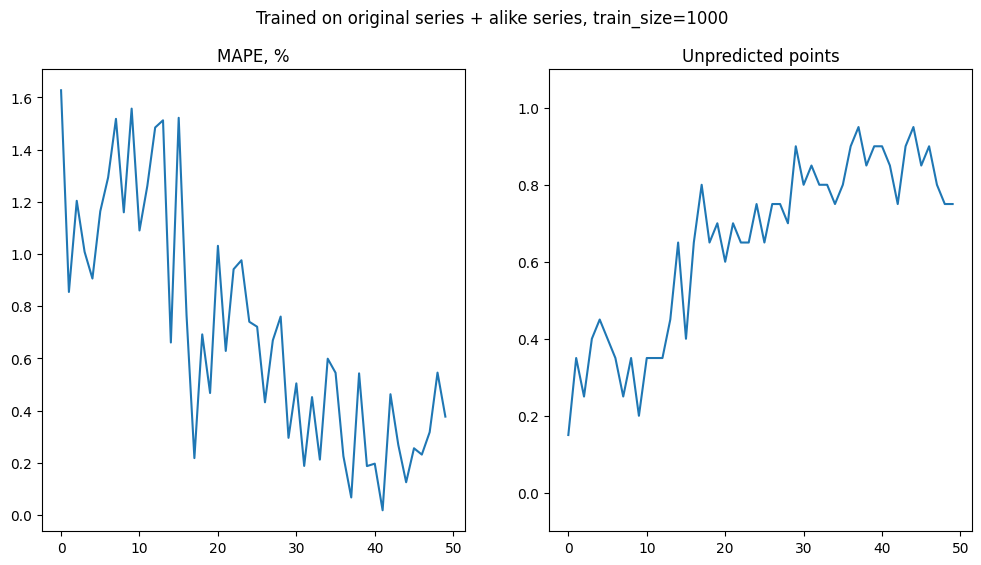

In [48]:
plots(train_points_number, data9)

In [49]:
print(np.mean(data9[3]))

0.648


Mixing 10

In [ ]:
mat10 = np.array([
    coeffs[places[9]]
])
data10 = calculate_mixed(train_points_number, begin, mat10 * params)

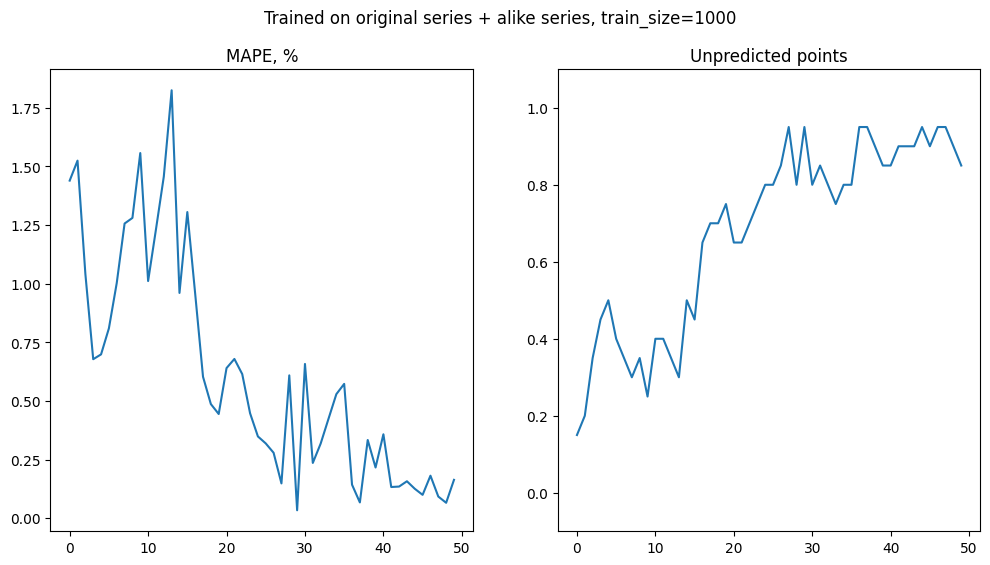

In [51]:
plots(train_points_number, data10)

In [52]:
print(np.mean(data10[3]))

0.6780000000000002


Mixing 11

In [ ]:
mat11 = np.array([
    coeffs[places[10]]
])
data11 = calculate_mixed(train_points_number, begin, mat11 * params)

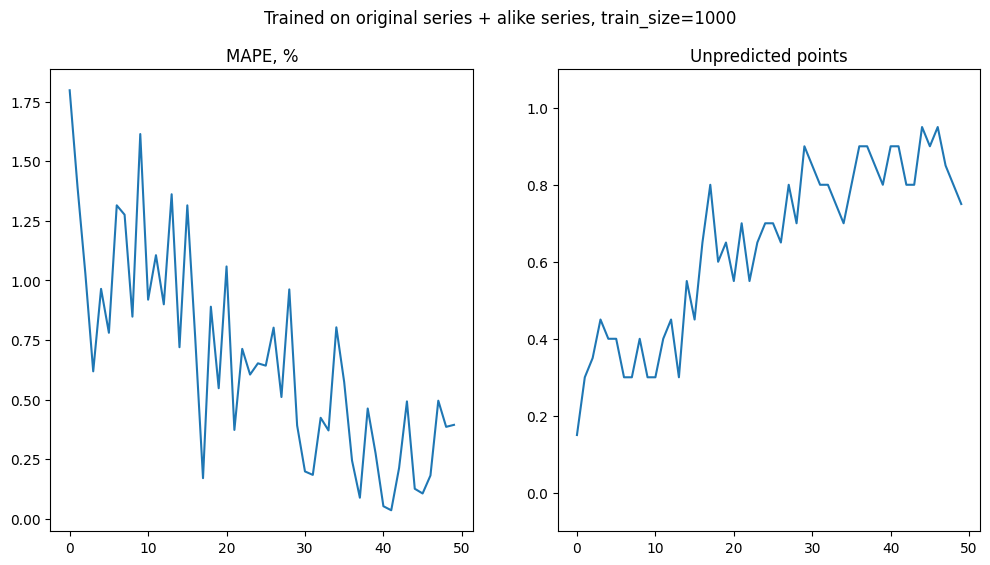

In [54]:
plots(train_points_number, data11)

In [55]:
print(np.mean(data11[3]))

0.6430000000000001


Mixing 12

In [ ]:
mat12 = np.array([
    coeffs[places[8]],
    coeffs[places[10]]
])
data12 = calculate_mixed(train_points_number, begin, mat12 * params)

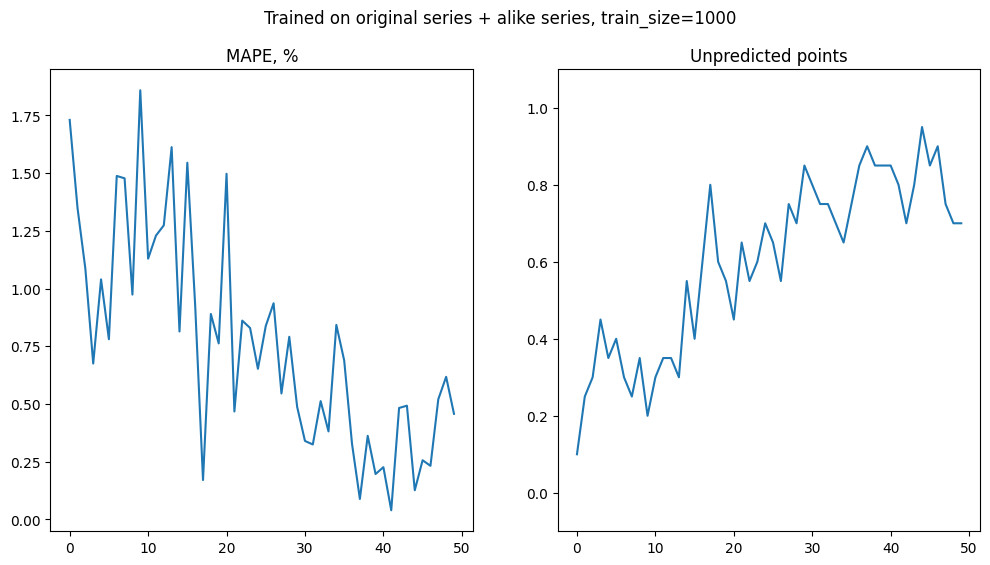

In [77]:
plots(train_points_number, data12)

In [78]:
print(np.mean(data12[3]))

0.601


Mixing 13

In [ ]:
mat13 = np.array([
    coeffs[places[3]],
    coeffs[places[8]],
    coeffs[places[10]]
])
data13 = calculate_mixed(train_points_number, begin, mat13 * params)

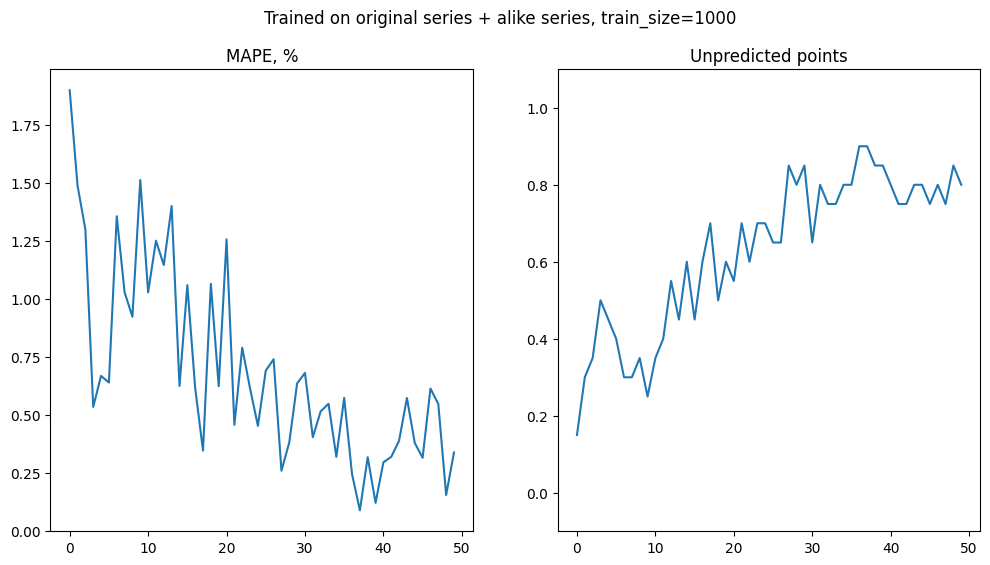

In [81]:
plots(train_points_number, data13)

In [82]:
print(np.mean(data13[3]))

0.6300000000000001


Mixing 14

In [ ]:
mat14 = np.array([
    coeffs[places[1]],
    coeffs[places[8]],
    coeffs[places[10]]
])
data14 = calculate_mixed(train_points_number, begin, mat14 * params)

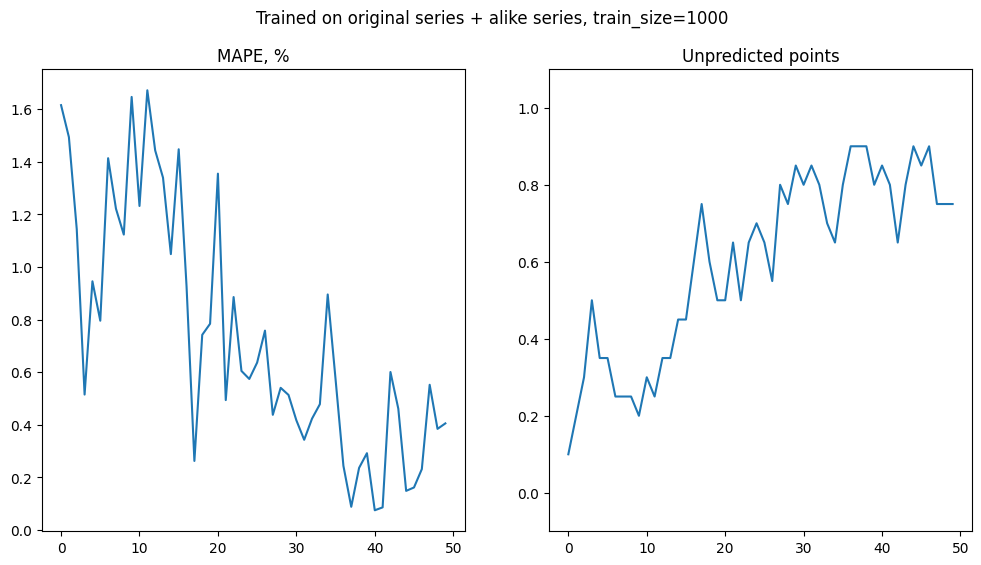

In [95]:
plots(train_points_number, data14)

In [96]:
print(np.mean(data14[3]))

0.601


Mixing 15

In [ ]:
mat15 = np.array([
    coeffs[places[2]],
    coeffs[places[8]],
    coeffs[places[10]]
])
data15 = calculate_mixed(train_points_number, begin, mat15 * params)

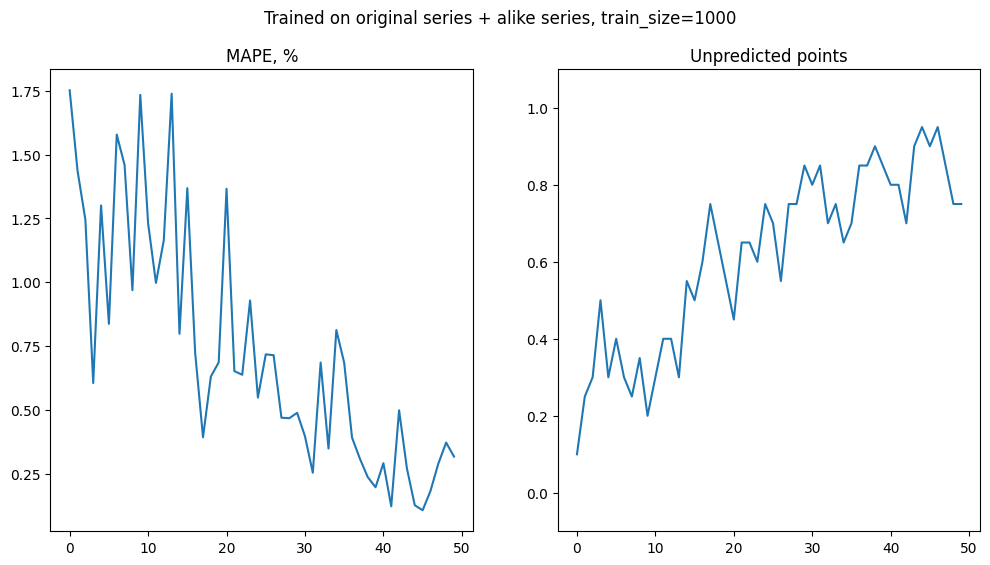

In [21]:
plots(train_points_number, data15)

In [22]:
print(np.mean(data15[3]))

0.618


Mixing 16

In [ ]:
mat16 = np.array([
    coeffs[places[1]],
    coeffs[places[2]],
    coeffs[places[8]],
    coeffs[places[10]]
])
data16 = calculate_mixed(train_points_number, begin, mat16 * params)

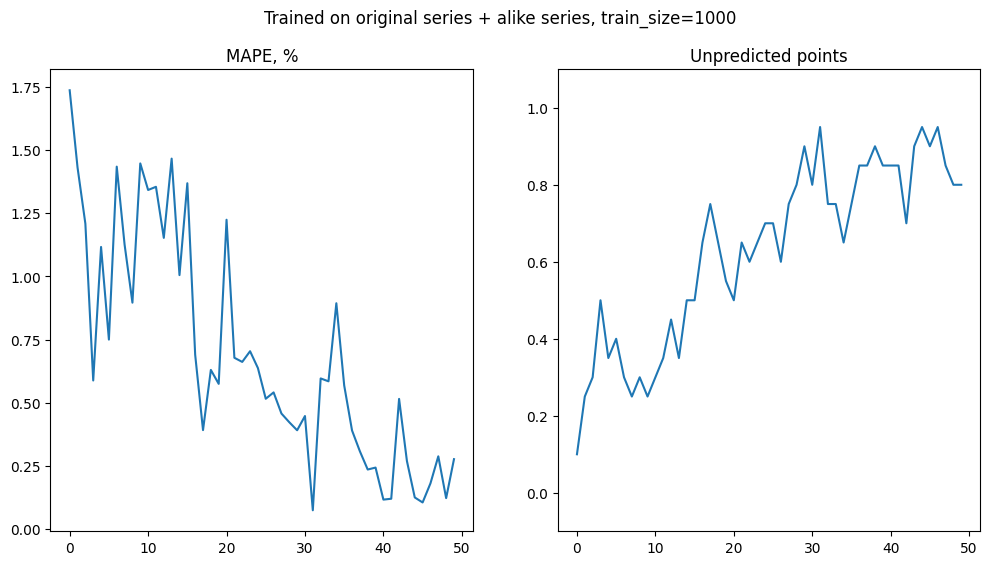

In [24]:
plots(train_points_number, data16)

In [25]:
print(np.mean(data16[3]))

0.6310000000000001


To CSV

In [26]:
import csv

DATA = [data15, data16]
with open('norm1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for i, data in enumerate(DATA):
        writer.writerow(list(map(str, data[2])))
        writer.writerow(list(map(str, data[3])))
        if i + 1 < len(DATA):
            writer.writerow("-" * 100)

Plots

In [7]:
MAPEs = []
unpredicted_points = []
with open('norm.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for i, row in enumerate(reader):
        if i % 3 == 0:
            MAPEs.append(list(map(float, row)))
        elif i % 3 == 1:
            unpredicted_points.append(list(map(float, row)))

In [59]:
from scipy.interpolate import make_interp_spline

def make_smooth_plot(y, label):
    y = np.array(y)
    x = np.arange(y.shape[0])
    X_Y_Spline = make_interp_spline(x, y)
 
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 1000)
    Y_ = X_Y_Spline(X_)
    
    # Plotting the Graph
    plt.plot(X_, Y_, label=label)
    # plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
    # plt.xlabel("X")
    # plt.ylabel("Y")
    # plt.show()

In [84]:
for i in [data12, data13]:
    unpredicted_points.append(i[3])

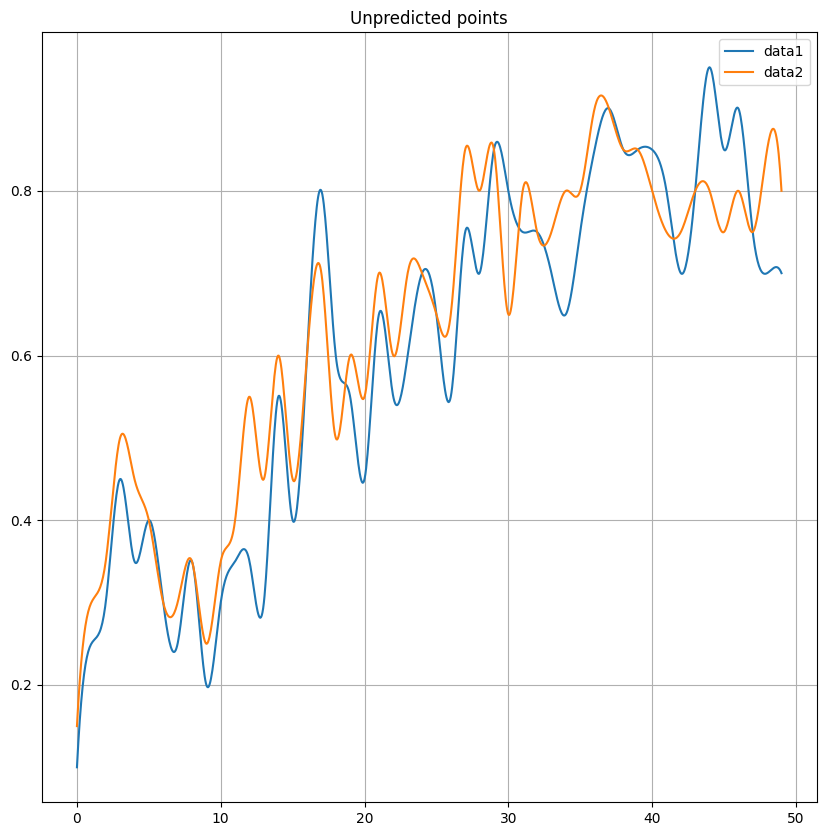

In [86]:
plt.figure(figsize=(10, 10))
plt.title("Unpredicted points")
for i, value in enumerate(unpredicted_points[-2:]):
    make_smooth_plot(value, label=f"data{i + 1}")
    # plt.plot(x, label=f"data{i + 1}")
plt.legend(loc="upper right")
plt.grid()
plt.show()

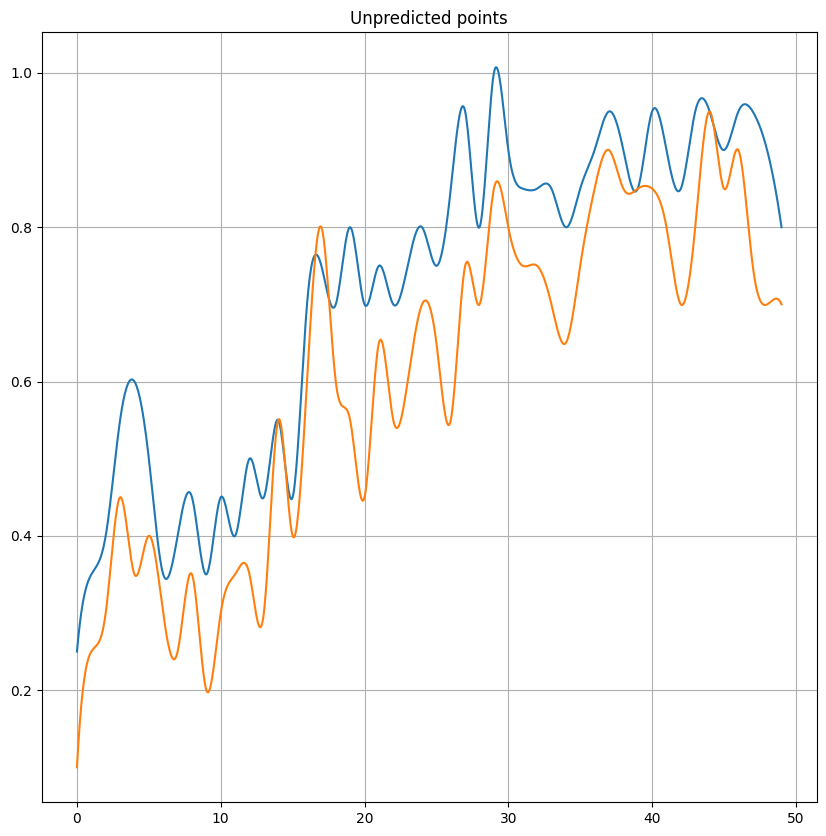

In [93]:
plt.figure(figsize=(10, 10))
plt.title("Unpredicted points")
make_smooth_plot(unpredicted_points[3], "")
make_smooth_plot(unpredicted_points[11], "")
plt.grid()
plt.show()